In [4]:
import nltk
import numpy as np
import collections
import re
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import SnowballStemmer
from csv_helper import CSVHelper
import sklearn as sk
nltk.download('stopwords')
nltk.download('wordnet')

data = CSVHelper.load_csv("Tweets_2016London.csv")

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
starting for loop!


In [5]:
def tokenize(tweets):
    tknzr = TweetTokenizer()
    tokenized_tweets = []
    for tweet in tweets:
        tokenized_tweets.append(tknzr.tokenize(tweet))
    return tokenized_tweets

def remove_stopwords(tweets):
    stopwords =  nltk.corpus.stopwords.words('english')
    stopwords.extend(("im","dont","wont"))
    tweets_nostop = []
    for tweet in tweets:
        tweet_nostop = [w.lower() for w in tweet if w.lower() not in stopwords]
        tweets_nostop.append(tweet_nostop)
    return tweets_nostop

def filter_names(tweets):
    tweets_filtered = []
    regex = re.compile("@([A-Za-z0-9_]+)")
    for tweet in tweets:
        tweet_filtered = [w for w in tweet if not regex.match(w)]
        tweets_filtered.append(tweet_filtered)
    return tweets_filtered

def filter_noise(tweets):
    tweets_filtered = []
    regex = re.compile("[^a-zA-Z]")
    for tweet in tweets:
        tweet_filtered = [re.sub("[^a-zA-Z]",'',w) for w in tweet if not regex.match(w)]
        tweets_filtered.append(tweet_filtered)
    return tweets_filtered

def remove_url(tweets):
    tweets_filtered = []
    regex = re.compile("^https?:\/\/.*[\r\n]*")
    for tweet in tweets:
        tweet_filtered = [w for w in tweet if not regex.match(w)]
        tweets_filtered.append(tweet_filtered)
    return tweets_filtered

#we decided to use a lemmatizer instead of stemming 
def my_stem(tweets):
    lmt = WordNetLemmatizer()
    ps = PorterStemmer()
    tweets_stemmed = []
    for tweet in tweets:
        tweet_stemmed = [lmt.lemmatize(w) for w in tweet]
        tweets_stemmed.append(tweet_stemmed)
    return tweets_stemmed

In [6]:
all_tweets = tokenize(data)
all_tweets = remove_url(all_tweets)
all_tweets = filter_names(all_tweets)
all_tweets = filter_noise(all_tweets)
all_tweets = remove_stopwords(all_tweets)
all_tweets = my_stem(all_tweets)


The function create_tfidf_features  (input = array of tokenized tweets output = tf-idf feature matrix) Creates a distinct vocabulary set, and a dictionary (key val pairs)for each word in the vocabulary, calculated the IDF value, and for each term in each tweet, calculates the tfidf score (which is just the term frequency * IDF value)


https://nlpforhackers.io/tf-idf/

https://www.youtube.com/watch?v=4vT4fzjkGCQ&t=1s

http://billchambers.me/tutorials/2014/12/21/tf-idf-explained-in-python.html

In [7]:
def termfreq(word, tweet):
    #print("tweet:", doc, "length of tweet:", len(doc))
    num_words = len(tweet)
    word_occurences = tweet.count(word)
    return word_occurences/num_words

def count_doc_with_term(word, tweets):
    counter = 0
    for tweet in tweets:
        if word in tweet:
            counter = counter + 1
    return counter

#idf = amount_of_tweets/amount_of_tweets_with_word
def idf(word, tweets):
    num_tweets = len(tweets)
    num_tweets_with_word = count_doc_with_term(word, tweets)
    return np.log10(num_tweets/num_tweets_with_word)

def create_vocabulary(tweets):
    vocabulary = set() #creates a new set named vocabulary (set doesn't have duplicates)
    for tweet in tweets: #iterates over all tweets
        words = [w for w in tweet] #makes a list of words in a tweet (which our loop currently is in)
        vocabulary.update(words)#update teh vocab set 
    return list(vocabulary)

def compute_word_idf(tweets, vocabulary):
    word_idf = collections.defaultdict(lambda: 0)    #when I call x[k] for a nonexistent key k (such as a statement like v=x[k]), the key-value pair (k,0) will be automatically added to the dictionary, as if the statement x[k]=0 is first executed.  
    for w in vocabulary: #looping across each word in library to calculate the word's idf
        word_idf[w] = idf(w, tweets) #taking the wordidf dictionaries' key as the word and putting value as the idf
    return word_idf
    
def tf_idf(word, tweet, tweets, word_idf):
    if tweet != []:
        return termfreq(word, tweet) * word_idf[word]
    else:
        return 0
    
def tweet_tfidf_features(tweets):
    vocabulary = create_vocabulary(tweets)
    word_idf = compute_word_idf(tweets, vocabulary)
    tweet_features = np.empty(len(tweets), dtype=object)
    for i, tweet in enumerate(tweets):
        a = np.zeros(len(vocabulary))
        for j, word in enumerate(vocabulary):
            a[j] = tf_idf(word, tweet, tweets,word_idf)
        tweet_features[i] = a
    return np.vstack(tweet_features)

What is happening inside tweet_tfidf_features?

1) vocabulary = create_vocabulary(tweets) Creates a vocabulary set (non duplicate values in all words)
2) word_idf = returns a dictionary where key is the word and value is the word's idk


In [8]:
#test = [["this","a","a","is","sample"],["this","another","another","is","example","example","example"]]
#test2 = [["new","times","york"],["new","post","york"],["angeles","los","times"],["pi","pa","po"],["teeet"],["teeet","o"],["pi","pa","po"]]
feature_matrix = tweet_tfidf_features(all_tweets)

In [9]:
feature_matrix.shape

(2001, 4480)

In [23]:
def euclidean_vectorized(A, B):    
    n, d = A.shape
    m, d1 = B.shape
    assert d == d1, 'Incompatible shape'
    A_squared = np.sum(np.square(A), axis=1, keepdims=True)
    B_squared = np.sum(np.square(B), axis=1, keepdims=True)
    AB = np.matmul(A, B.T)
    distances = np.sqrt(A_squared - 2 * AB + B_squared.T)
    return distances

# X: data matrix of size (n_samples,n_features)
# n_clusters: number of clusters
# output 1: labels of X with size (n_samples,)
# output 2: centroids of clusters
def kmeans(X,n_clusters):
    # initialize labels and prev_labels. prev_labels will be compared with labels to check if the stopping condition
    # have been reached.
    prev_labels = np.zeros(X.shape[0])
    labels = np.zeros(X.shape[0])
    
    # init random indices
    # YOUR CODE GOES HERE
    indices = np.random.choice(X.shape[0], n_clusters, replace=False)# np.random.permutation(X.shape[0])[:n_clusters]
    
    # assign centroids using the indices
    # YOUR CODE GOES HERE
    centroids = X[indices]
    
    # the interative algorithm goes here
    while (True):
        # calculate the distances to the centroids
        distances = sk.metrics.pairwise.cosine_distances(X,centroids)
       
        # assign labels
        labels = np.argmin(distances,axis=1)
        # stopping condition
        if np.array_equal(labels, prev_labels):
        #if np.sum(labels != prev_labels) == 0:
            break
        
        # calculate new centroids
        for cluster_indx in range(centroids.shape[0]):
            members = X[labels == cluster_indx]
            centroids[cluster_indx,:] = np.mean(members,axis=0)
        
        #plt.plot(labels, 'ro')
        #plt.show()
        
        # keep the labels for next round's usage
        prev_labels = np.argmin(distances,axis=1)
    
    return labels,centroids
    

In [24]:
from sklearn.cluster import KMeans
num_clusters = 2
cluster_labels,centroids = kmeans(feature_matrix,num_clusters)

-0.0756816463043
silhouette score for k= 2 is: -0.0860987233676
silhouette score for k= 3 is: -0.0684845622263
silhouette score for k= 4 is: -0.0837150430126
silhouette score for k= 5 is: -0.104730284741
silhouette score for k= 6 is: -0.0831267245475
silhouette score for k= 7 is: -0.100851644488
silhouette score for k= 8 is: -0.0961407939351
silhouette score for k= 9 is: -0.0965392642322
silhouette score for k= 10 is: -0.0702372080998
silhouette score for k= 11 is: -0.0854956713395
silhouette score for k= 12 is: -0.0678328591365
silhouette score for k= 13 is: -0.0845912970313
silhouette score for k= 14 is: -0.0975461258744
silhouette score for k= 15 is: -0.0781852019045


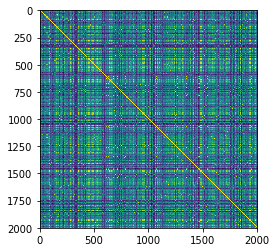

In [25]:
import sklearn
from sklearn.metrics import silhouette_score
print(silhouette_score(feature_matrix, cluster_labels))

nclusters_to_test = 16
consensus_matrix = np.zeros((feature_matrix.shape[0],feature_matrix.shape[0]))

for i in range(2,nclusters_to_test):
    cluster_labels, centroids = kmeans(feature_matrix, i)
    sil_score = silhouette_score(feature_matrix, cluster_labels)
    print("silhouette score for k=",i, 'is:',sil_score)
    for i in range(len(cluster_labels)):
        for j in range(len(cluster_labels)):
            if cluster_labels[i] == cluster_labels[j]:
                consensus_matrix[i,j] = (consensus_matrix[i,j] + 1)
                #print(cluster_labels[i],cluster_labels[j],consensus_matrix[i,j])
                
import matplotlib.pyplot as plt

plt.imshow(consensus_matrix)
plt.legend()
plt.show()

#print(pd.DataFrame(consensus_matrix))

<h3>Additional post-processing step:</h3>
In this step, if a pair (i, j) of tweets did not cluster together more than 10% of the total number of runs, the position (i, j) in the consensus matrix is set to 0.

In [26]:
print(pd.DataFrame(consensus_matrix))

      0     1     2     3     4     5     6     7     8     9     ...   1991  \
0     14.0   4.0   3.0   6.0   2.0   4.0   5.0   3.0   5.0   5.0  ...    2.0   
1      4.0  14.0   8.0  12.0   8.0  11.0  13.0  10.0   7.0   8.0  ...   10.0   
2      3.0   8.0  14.0   8.0   8.0   8.0   8.0   8.0   5.0   6.0  ...    7.0   
3      6.0  12.0   8.0  14.0   8.0  12.0  13.0  10.0   8.0   8.0  ...   10.0   
4      2.0   8.0   8.0   8.0  14.0   8.0   8.0   8.0   5.0   6.0  ...    8.0   
5      4.0  11.0   8.0  12.0   8.0  14.0  12.0  10.0   7.0   8.0  ...   10.0   
6      5.0  13.0   8.0  13.0   8.0  12.0  14.0  10.0   8.0   9.0  ...   10.0   
7      3.0  10.0   8.0  10.0   8.0  10.0  10.0  14.0   6.0   7.0  ...    9.0   
8      5.0   7.0   5.0   8.0   5.0   7.0   8.0   6.0  14.0   6.0  ...    5.0   
9      5.0   8.0   6.0   8.0   6.0   8.0   9.0   7.0   6.0  14.0  ...    6.0   
10     5.0   7.0   5.0   8.0   5.0   8.0   8.0   6.0  13.0   6.0  ...    5.0   
11     2.0   4.0   3.0   4.0   4.0   5.0

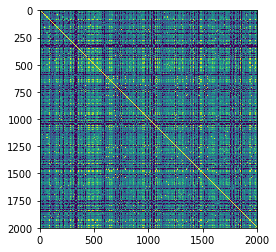

In [27]:
for i in range(len(consensus_matrix)):
    for j in range(len(consensus_matrix)):
        if consensus_matrix[i,j] <= 2:
            consensus_matrix[i,j] = 0

plt.imshow(consensus_matrix)
plt.legend()
plt.show()

#print(pd.DataFrame(consensus_matrix))

<h3>remove Noise points</h3>
To detect noise, we will look at the row sums for the consensus
matrix and employed a threshold
value. Tweets, whose row sum are less than that threshold val
ue are, marked as noise points. The
threshold value is determined by the average of all the entri
es in the constructed consensus matrix.

In [32]:
row_mean = consensus_matrix.mean(1)
matrix_mean = consensus_matrix.mean()

#create clean tweats that removes the noise points
clean_tweets = []
for i in range(len(all_tweets)):
    if row_mean[i] >= matrix_mean:
        clean_tweets.append(all_tweets[i])
        
len(clean_tweets)

1078

Running k-Means with the consensus matrix as input, number of clusters = 9

In [29]:
cluster_labels,centroids = kmeans(consensus_matrix,9)
print(silhouette_score(consensus_matrix, cluster_labels))

0.164453169778


DBSCAN

In [33]:
def find_eps_neighborhood(distances, ind, eps):
    ''' 
    Input arguments:
        - distances: a matrix containing distances between all pairs of points in the dataset
        - ind: index of the point of interest
        - eps: the epsilon parameter
    Output:
        - Retun a set of points in the neighborhood. 
        (Note: Use Set data structure in Python)
    '''
    ### YOUR CODE HERE ###
    eps_neighbors = np.nonzero(distances[ind] <= eps)[0]
    return set(eps_neighbors.tolist())

In [34]:
def find_reachable_pts(distances, eps, ind):
    eps_neighbors = find_eps_neighborhood(distances, ind, eps)
    reachables = eps_neighbors
    new_pts = copy.deepcopy(eps_neighbors)
    new_pts.remove(ind)
    while len(new_pts) > 0:
        pt = new_pts.pop() 
        pt_neighbors = find_eps_neighborhood(distances, pt, eps)
        additional_pts = pt_neighbors.difference(reachables)
        reachables.update(additional_pts)
        new_pts.update(additional_pts)
    return reachables

In [37]:
def dbscan(X, eps, minPts):
    ''' a simple implementation of DBSCAN algorithm
    In this implementation, a point is represented by its index in the dataset. 
    In this function, except for the step to calculate the Euclidean distance,
    we will only work with the points't indices.
    
    Input arguments:
        - X: the dataset
        - eps: the epsilon parameter
        - minPts: the minimum number of points for a cluster
    Output:
        - core_points: a list containing the indices of the core points
        - cluster_labels: a Numpy array containing labels for each point in X
        - outliers: a list containing the indices of the outlier points
    '''
    # a list to keep track of the unvisited points
    unvisited = list(range(X.shape[0]))
    # list of core points (or cluster centroids)
    core_points = list([])
    # list of clusters, each cluster is a set of points
    clusters = list([])
    # list of outlier points (or noises)
    outliers = list([])
    distances = sk.metrics.pairwise.cosine_distances(X, X) #we already have this function above defines in K-means
    
    while True:
        # randomly choose a point, p, from the list of unvisited points
        ind = np.random.choice(unvisited, size=1)[0] ### YOUR CODE HERE ###
        
        # find the eps-neighborhood of the chosen point p
        eps_neighbors = find_eps_neighborhood(distances, ind, eps) ### YOUR CODE HERE ###
        
        # check if p is a core point or not
        is_core_pt = len(eps_neighbors) >= minPts ### YOUR CODE HERE ###
        
        if is_core_pt:
            # add the chosen index to the core_points list
            ### YOUR CODE HERE ###
            core_points.append(ind)
            
            # find all reachable points from p w.r.t eps and form a new cluster
            new_cluster = find_reachable_pts(distances, eps, ind) ### YOUR CODE HERE ###
            
            # add the newly formed cluster to the list of cluster
            ### YOUR CODE HERE ###
            clusters.append(new_cluster)
            
            # remove the indices in the new_cluster from the unvisited list and the outlier list,
            # if they were added to either those list before
            ### YOUR CODE HERE ###
            for ind in new_cluster:
                if ind in unvisited:
                    unvisited.remove(ind)
                if ind in outliers:
                    outliers.remove(ind) 
            
        else:
            # if not core point, add p to the list of outlier points
            ### YOUR CODE HERE ###
            outliers.append(ind)
        
        # remove the chosen index from the unvisited list (if it is still inside this list)
        ### YOUR CODE HERE ###
        if ind in unvisited:
            unvisited.remove(ind)
            
        # if there is no point left in the unvisited list, stop the loop
        if len(unvisited) == 0:
            break
    
    # convert the resulting cluster list to cluster_labels
    cluster_labels = np.zeros(X.shape[0])
    for i in range(len(clusters)):
        for j in clusters[i]:
            cluster_labels[j] = i

    return core_points, cluster_labels, outliers

In [46]:
import copy 
eps = 0.999
minPts = 6
core_points, cluster_labels, outliers = dbscan(feature_matrix, eps, minPts)
print('%d clusters found' %(len(core_points)))
print('%d outlier points detected' %(len(outliers)))


# Calculate the shlhouette score
if len(core_points) > 1:
    print('Silhouette score: %f' %silhouette_score(feature_matrix, cluster_labels))
else:
    print('Cannot evaluate silhouetter score with only one cluster')

1 clusters found
53 outlier points detected
Cannot evaluate silhouetter score with only one cluster


[1526]
[ 0.  0.  0. ...,  0.  0.  0.]
[138, 1536, 976, 385, 860, 1694, 257, 43, 1539, 1420, 1153, 1315, 909, 256, 1907, 659, 1478, 383, 808, 1793, 57, 18, 354, 1874, 1060, 844, 441, 82, 1892, 1986, 1492, 845, 1514, 1521, 718, 824, 1930, 1456, 409, 1885, 1088, 353, 490, 1613, 1446, 1538, 1912, 122, 1908, 651, 1348, 1784, 941]


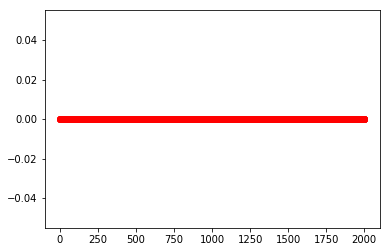

In [45]:
core_points, cluster_labels, outliers = dbscan(feature_matrix, 0.9, 6)

print(core_points)
print(cluster_labels)
print(outliers)

plt.plot(cluster_labels, 'ro')
plt.show()

In [ ]:


for eps in range(0.1,0.99,0.05)
    core_points, cluster_labels, outliers = dbscan(feature_matrix, eps, 6)
    #sil_score = silhouette_score(feature_matrix, cluster_labels)
    #print("silhouette score for k=",i, 'is:',sil_score)
    for i in range(feature_matrix.shape[0]):
        for j in range(len(feature_matrix.shape[0]):
            
